In [2]:
import torch
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [3]:
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
        in_channels=3, out_channels=1, init_features=32, pretrained=True)

Using cache found in /home/rfit/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [4]:
class diceloss(torch.nn.Module):
    def init(self):
        super(diceLoss, self).init()
    def forward(self,pred, target):
       smooth = 1.
       iflat = pred.contiguous().view(-1)
       tflat = target.contiguous().view(-1)
       intersection = (iflat * tflat).sum()
       A_sum = torch.sum(iflat * iflat)
       B_sum = torch.sum(tflat * tflat)
       return 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth) )

In [5]:
from torchvision import transforms, datasets

In [6]:


import os
import glob
from PIL import Image
import torch
from torch.utils.data import Dataset,DataLoader,IterableDataset
from torch.autograd import Variable

data_transform = transforms.Compose([
    
        transforms.ToTensor(),
        transforms.Resize((256,256)),
#         transforms.RandomSizedCrop(224),
#         transforms.RandomHorizontalFlip(),
#         transforms.Lambda(lambda x: x/255)
    ])
mask_transform = transforms.Compose([
    
        transforms.ToTensor(),
        transforms.Resize((256,256)),
        transforms.Grayscale(num_output_channels=1),
#         transforms.RandomSizedCrop(224),
#         transforms.RandomHorizontalFlip(),
#         transforms.Lambda(lambda x: x/255)
    ])

class Transform(transform):
    def __init__(self,vert_flip,hor_flip):
        self.vert_flip = vert_flip
        self.hor_flip  = hor_flip
class ImageFolderSegmentation(IterableDataset):
    """
        A generic data loader for image segmentation where the data
        are organised as:

        ....

        Parameters
        ----------
        root : str
            Root folder containing the segmentation data.
        images_path : str
            path of the images with selector
            image_path = '/image/*.png'
        label_path : str
            path of the labals with selector
        conversion : str
            conversion for input images
        transform : Composed Transformation
            transformation applied on input images
        label_transform : Composed Transformation
            transformation applied on label images

        Attributes
        ----------
        image_filenames : list of str
            images names with full path
        label_filenames : list of str
            label names with full path
        conv: list of str
            conversion List

        Examples
        --------

        >>> from dataloaderSegmentation import ImageFolderSegmentation
        >>> image_path = '/image/*.png'
        >>> label_path = '/label/*.png'
        >>> data = ImageFolderSegmentation(image_path=image_path,
        ...                                label_path=label_path)


    """

    def __init__(self, images_path, label_path, conversion='RGB',
                 transform=None,
                 label_transform=None):

        self.image_filenames = sorted(glob.glob(images_path))
        self.label_filenames = sorted(glob.glob(label_path))

        self.conversion = conversion
        for imf, lf in zip(self.image_filenames,
                                       self.label_filenames):
            if not(self._get_filename(imf) == self._get_filename(lf)):
#         if not all([self._get_filename(imf) == self._get_filename(lf)
#                     for imf, lf in zip(self.image_filenames,
#                                        self.label_filenames)]):
                raise ValueError(
                    f'Image names in Images and label have to be identical. Look {imf} and {lf}')
        self.transform = transform
        self.label_transform = label_transform

    def _get_filename(self, path):
        return os.path.basename(os.path.splitext(path)[0])

    def _pil_loader(self, path, conversion=None):
        with open(path, 'rb') as f:
            if conversion is not None:
                return Image.open(f).convert(conversion)
            else:
                return cv2.imread(path)

    def __getitem__(self, index):
        '''Get an image and a label'''

        image = self._pil_loader(path=self.image_filenames[index],
                                 conversion='RGB')
        label = self._pil_loader(path=self.label_filenames[index])

        if self.transform is not None:
            image = self.transform(image)
        if self.label_transform is not None:
            label = self.label_transform(label)
        return (image, label)

    def __len__(self):
        return len(self.image_filenames)
    def __iter__(self):
        self.value = 0
        return self
    def __next__(self):
        if self.value>=self.__len__():
            raise StopIteration
        else:
            index = self.value
            image = self._pil_loader(path=self.image_filenames[index],
                                 conversion='RGB')
            label = self._pil_loader(path=self.label_filenames[index])

            if self.transform is not None:
                image = self.transform(image)
            if self.label_transform is not None:
                label = self.label_transform(label)
            self.value+=1
            return (image, label)

    def __repr__(self):
        fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
        tmp = '    Transforms (if any): '
        fmt_str += '{0}{1}\n'.format(tmp,
                                     self.transform.__repr__().replace(
                                         '\n', '\n' + ' ' * len(tmp)))
        tmp = '    Label Transforms (if any): '
        fmt_str += '{0}{1}'.format(tmp,
                                   self.label_transform.__repr__().replace(
                                       '\n', '\n' + ' ' * len(tmp)))
        return fmt_str


In [7]:
data_train = ImageFolderSegmentation('../resize_images/*','../marking/*',None,
                               transform = data_transform,label_transform = mask_transform)
data_val = ImageFolderSegmentation('../resize_images_val/*','../marking_val/*',None,
                               transform = data_transform,label_transform = mask_transform)
print(len(data_train),len(data_val))

72 46


In [74]:
data_val[0][1].max()

tensor(0.9999)

In [8]:
train = DataLoader(data_train, batch_size=16, shuffle=False)
val = DataLoader(data_val, batch_size=16, shuffle=False)

TypeError: 'DataLoader' object does not support indexing

In [9]:
def ten2im(im):
    return np.transpose(im,(1,2,0))

(torch.Size([3, 256, 256]), torch.Size([1, 256, 256]))

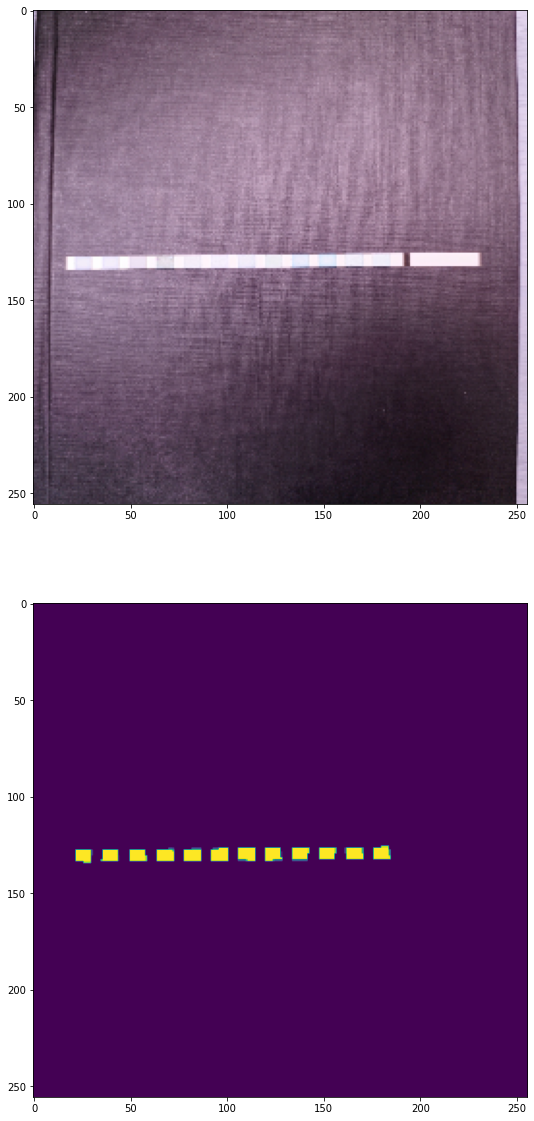

In [66]:
fig,ax = plt.subplots(2,1,figsize=(10,20))
ax[0].imshow(ten2im(data_val[-1][0]))
ax[1].imshow(ten2im(data_val[-1][1]))
data_train[21][0].shape,data_train[21][1].shape

In [144]:
from torch.utils.tensorboard import SummaryWriter
import numpy as np

writer = SummaryWriter(log_dir='log_dir')

In [ ]:
writer.add_image()

In [148]:
for n_iter in range(100):
    writer.add_scalar('Loss/train', np.random.random(), n_iter)
    writer.add_scalar('Loss/test', np.random.random(), n_iter)
    writer.add_scalar('Accuracy/train', np.random.random(), n_iter)
    writer.add_scalar('Accuracy/test', np.random.random(), n_iter)

In [140]:
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
        in_channels=3, out_channels=1, init_features=32, pretrained=True)

Using cache found in /home/rfit/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [116]:
optimizer = torch.optim.Adam(model.parameters())
loss_fun = diceloss()
num_epochs = 100
device= 'cuda'
model.to(device)
for ep in range(num_epochs):
    for (i,l) in train:
#         print('teain',i.max(),l.max())
        model.train()
#         print(i.shape,l.shape)
        optimizer.zero_grad()
        i= i.to(device)
        l = l.to(device)
#         l=l.long()
        outt = model(i)
#         pred = torch.Variable(torch.argmax(outt['out'],1).float(),requires_grad=True).cuda()
        pred=outt
#         print(pred.shape,l.shape)
        loss = loss_fun(pred,l.type(torch.cuda.FloatTensor))
        loss.backward()
        optimizer.step()
        print(loss,end ='\r')
    val_loss=0
    model.eval()
    images =[]
    labels = []
    for (i_v,l_v) in val:
#         print('val',i_v.max(),l_v.max())
        with torch.no_grad():
            i_v=i_v.to(device)
            l_v = l_v.to(device)
#             l_v=l_v.long()
            outt = model(i_v)
#             pred = Variable(torch.argmax(outt['out'],1).float(),requires_grad=True).cuda()
            pred=outt
    #         print(pred.shape,l.shape)
            loss = loss_fun(pred,l_v.type(torch.cuda.FloatTensor))
            val_loss+=loss.item()
            
    print(f'vaidation mean loss is:{val_loss/(len(val))} in {ep} epoch')
            
    
#     print(ep,outt)
# torch.save(model, 'models/newnet.pth')

vaidation mean loss is:0.6861974199612936 in 0 epochd1>)
vaidation mean loss is:0.7690989375114441 in 1 epochd1>)
vaidation mean loss is:0.8909681042035421 in 2 epochd1>)
vaidation mean loss is:0.7374581297238668 in 3 epochd1>)
vaidation mean loss is:0.8717233339945475 in 4 epochd1>)
vaidation mean loss is:0.6915305058161417 in 5 epochd1>)
vaidation mean loss is:0.8108609120051066 in 6 epochd1>)
vaidation mean loss is:0.8159483472506205 in 7 epochd1>)
vaidation mean loss is:0.7557572921117147 in 8 epochd1>)
vaidation mean loss is:0.7301005522410074 in 9 epochd1>)
vaidation mean loss is:0.7554989258448283 in 10 epoch1>)
vaidation mean loss is:0.6733928720156351 in 11 epoch1>)
vaidation mean loss is:0.691332479317983 in 12 epochd1>)
vaidation mean loss is:0.7255427837371826 in 13 epoch1>)
vaidation mean loss is:0.6495567162831625 in 14 epoch1>)
vaidation mean loss is:0.7149008711179098 in 15 epoch1>)
vaidation mean loss is:0.698458711306254 in 16 epochd1>)
vaidation mean loss is:0.639826

In [121]:
import time

In [133]:
val_loss=0
model.eval()
device= 'cpu'
model.to(device)
for (i_v,l_v) in val:
    print('val',i_v.max(),l_v.max())
    with torch.no_grad():
        i_v=i_v.to(device)
        l_v = l_v.to(device)
#         l_v=l_v.long()
#         print(l_v.max())
        s= time.time()
        outt = model(i_v)
#             pred = Variable(torch.argmax(outt['out'],1).float(),requires_grad=True).cuda()
        print(time.time()-s)
        pred=outt
#         print(pred.shape,l.shape)
        loss = loss_fun(pred,l_v)
        val_loss+=loss.item()
print(f'vaidation mean loss is:{val_loss/(len(val))}')

val tensor(1.) tensor(0.9999)
1.5053577423095703
val tensor(1.) tensor(0.9999)
1.5894653797149658
val tensor(1.) tensor(0.9999)
1.283790111541748
vaidation mean loss is:0.5754407445589701


In [134]:
i_v.shape,l_v.shape,pred.shape

(torch.Size([14, 3, 256, 256]),
 torch.Size([14, 1, 256, 256]),
 torch.Size([14, 1, 256, 256]))

In [135]:
np.array(l_v.cpu()).max()

0.99990004

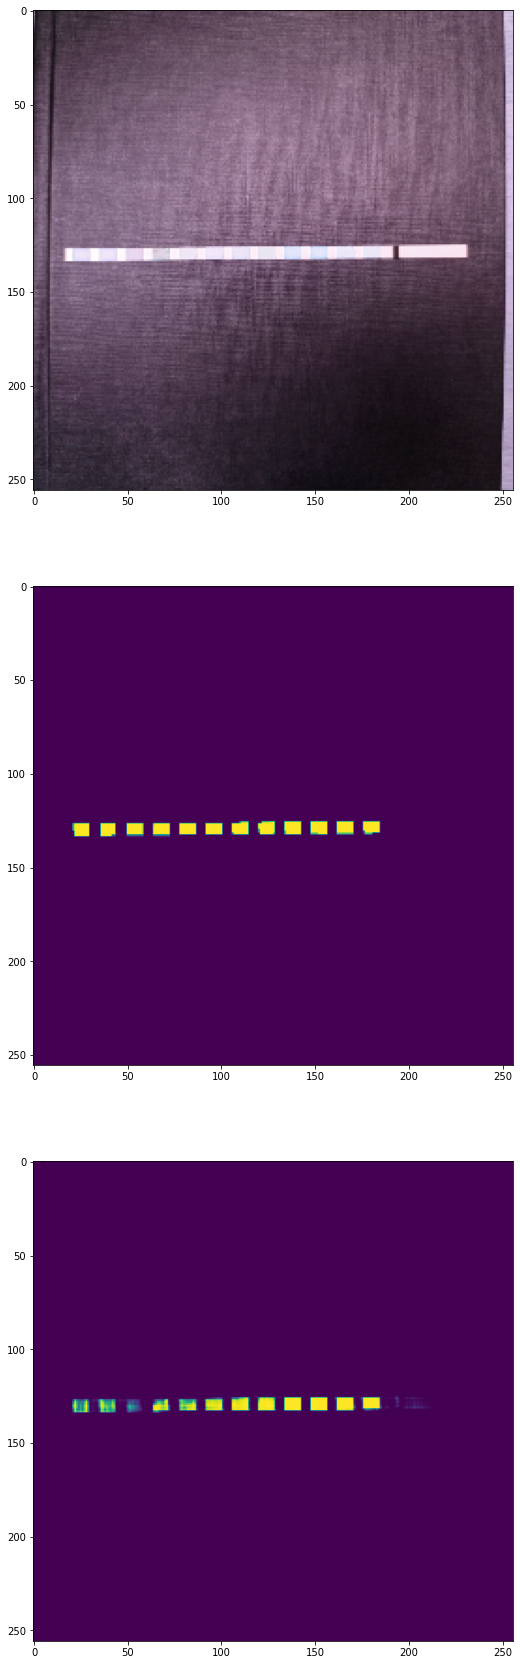

In [136]:
i=12
fig,ax = plt.subplots(3,1,figsize=(10,30))
ax[0].imshow(ten2im(np.array(i_v[i].cpu())))
ax[1].imshow(ten2im(np.array(l_v[i].cpu())))
ax[2].imshow(ten2im(np.array(pred[i].cpu())))

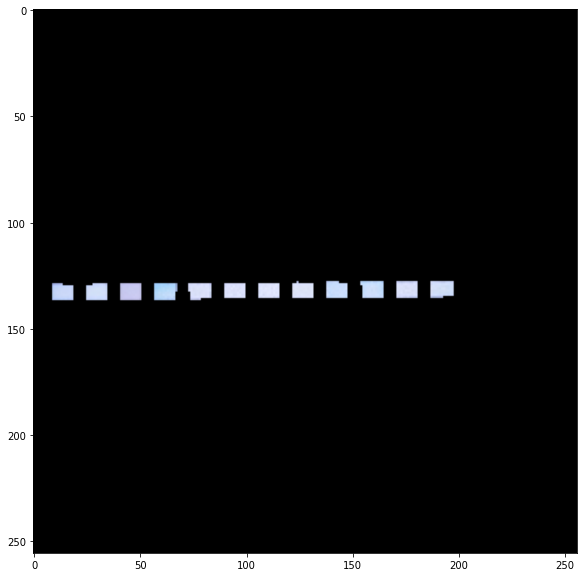

In [115]:
i=21
im= ten2im(np.array(data_val[i][0].cpu()))
mask = ten2im(np.array(data_val[i][1].cpu()))
m_im = np.where(mask>0.7,im,0)
plt.figure(figsize=(10,10))
plt.imshow(m_im)

In [22]:
class TestDataset(IterableDataset):
    """
        A generic data loader for image segmentation where the data
        are organised as:

        ....

        Parameters
        ----------
        root : str
            Root folder containing the segmentation data.
        images_path : str
            path of the images with selector
            image_path = '/image/*.png'
        label_path : str
            path of the labals with selector
        conversion : str
            conversion for input images
        transform : Composed Transformation
            transformation applied on input images
        label_transform : Composed Transformation
            transformation applied on label images

        Attributes
        ----------
        image_filenames : list of str
            images names with full path
        label_filenames : list of str
            label names with full path
        conv: list of str
            conversion List

        Examples
        --------

        >>> from dataloaderSegmentation import ImageFolderSegmentation
        >>> image_path = '/image/*.png'
        >>> label_path = '/label/*.png'
        >>> data = ImageFolderSegmentation(image_path=image_path,
        ...                                label_path=label_path)


    """

    def __init__(self, images_path, label_path, conversion='RGB',
                 transform=None,
                 label_transform=None):

        self.image_filenames = sorted(glob.glob(images_path))

        self.conversion = conversion
        self.transform = transform
        self.label_transform = label_transform

    def _get_filename(self, path):
        return os.path.basename(os.path.splitext(path)[0])

    def _pil_loader(self, path, conversion=None):
        with open(path, 'rb') as f:
            if conversion is not None:
                return Image.open(f).convert(conversion)
            else:
                return cv2.imread(path)

    def __getitem__(self, index):
        '''Get an image and a label'''

        image = self._pil_loader(path=self.image_filenames[index],
                                 conversion='RGB')

        if self.transform is not None:
            image = self.transform(image)
        
        return (image)

    def __len__(self):
        return len(self.image_filenames)
    def __iter__(self):
        self.value = 0
        return self
    def __next__(self):
        if self.value>=self.__len__():
            raise StopIteration
        else:
            index = self.value
            image = self._pil_loader(path=self.image_filenames[index],
                                 conversion='RGB')

            if self.transform is not None:
                image = self.transform(image)
            self.value+=1
            return (image, label)

    def __repr__(self):
        fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
        tmp = '    Transforms (if any): '
        fmt_str += '{0}{1}\n'.format(tmp,
                                     self.transform.__repr__().replace(
                                         '\n', '\n' + ' ' * len(tmp)))
        return fmt_str


In [125]:
test = TestDataset('../data/not_used(test)/*',None,
                               transform = data_transform)
test

Dataset TestDataset
    Number of datapoints: 3
    Transforms (if any): Compose(
                             ToTensor()
                             Resize(size=(256, 256), interpolation=bilinear)
                         )

In [127]:
model.eval()
model.cuda()
with torch.no_grad():
    im = test[0].unsqueeze((0)).cuda()
    pred = model(im)
    im = im.cpu()
    pred = pred.cpu()

In [128]:
pred

tensor([[[[3.3441e-05, 8.6078e-06, 1.1653e-05,  ..., 7.2351e-06,
           9.2757e-06, 3.6254e-05],
          [4.4780e-05, 1.1777e-06, 3.1722e-06,  ..., 2.3110e-06,
           3.1263e-06, 3.0641e-05],
          [5.8650e-05, 2.3301e-07, 4.2126e-07,  ..., 3.0480e-07,
           8.2893e-07, 1.3660e-05],
          ...,
          [9.0561e-05, 2.7743e-07, 9.0344e-07,  ..., 6.0621e-08,
           1.7185e-07, 1.2329e-05],
          [1.1560e-04, 1.5362e-06, 5.7178e-06,  ..., 5.6837e-07,
           8.8227e-07, 2.4631e-05],
          [4.5287e-05, 5.4639e-06, 8.5279e-06,  ..., 2.6117e-06,
           3.6843e-06, 2.6600e-05]]]])

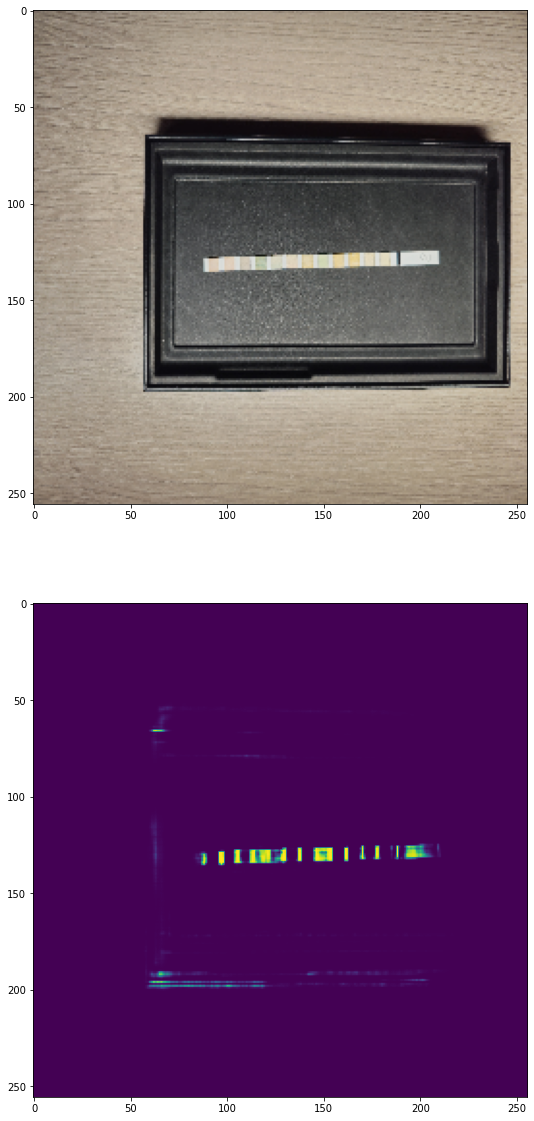

In [129]:
fig,ax = plt.subplots(2,1,figsize=(10,20))
ax[0].imshow(ten2im(np.array(im[0])))
ax[1].imshow(ten2im(np.array(pred[0])))

In [45]:
np.array(im[0])

array([[[0.48956415, 0.50222886, 0.5294041 , ..., 0.61665905,
         0.61109453, 0.5970167 ],
        [0.44938725, 0.4672909 , 0.439951  , ..., 0.6042088 ,
         0.59660697, 0.63026196],
        [0.5067594 , 0.50804234, 0.5471316 , ..., 0.45365348,
         0.4868911 , 0.48429456],
        ...,
        [0.4538335 , 0.49842983, 0.4764591 , ..., 0.5913335 ,
         0.5853554 , 0.55624235],
        [0.5126341 , 0.49280408, 0.47640935, ..., 0.5728516 ,
         0.55487514, 0.552811  ],
        [0.50823   , 0.5035463 , 0.4987477 , ..., 0.57667357,
         0.5737707 , 0.562929  ]],

       [[0.43702894, 0.45124847, 0.4901884 , ..., 0.5578355 ,
         0.552271  , 0.5359873 ],
        [0.3949755 , 0.40846738, 0.3889706 , ..., 0.5444049 ,
         0.5333602 , 0.56893003],
        [0.46631816, 0.46288678, 0.50065875, ..., 0.39875153,
         0.42810586, 0.42154947],
        ...,
        [0.3910884 , 0.43568477, 0.4194738 , ..., 0.52159166,
         0.51476717, 0.4749311 ],
        [0.4